In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pathlib import Path
import xarray as xr
import tensorflow as tf
from hmpai.models import *
from hmpai.utilities import *
from hmpai.training import train_and_evaluate, split_data_on_participants, k_fold_cross_validate, get_compile_kwargs
from hmpai.normalization import *
from hmpai.generators import *
from hmpai.visualization import *
from mne.viz import plot_topomap
from mne.io import read_info
from alibi.explainers import IntegratedGradients
from functools import partial
# tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()
# tf.compat.v1.experimental.output_all_intermediates(True)
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env TF_GPU_ALLOCATOR=cuda_malloc_async

2023-10-24 16:22:13.188820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 16:22:13.950944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [2]:
data_path = Path("../data/sat1/split_stage_data.nc")

data = xr.load_dataset(data_path)
set_global_seed(42)
train_data, val_data, test_data = split_data_on_participants(data, 60, norm_dummy)

In [3]:
tf.keras.backend.clear_session()
positions = read_info(Path("data/sat1/preprocessed/processed_0001_epo.fif"))
# model = tf.keras.models.load_model("models/gru")
model_cnn = tf.keras.models.load_model("models/cnn_base_test")
model_gru = tf.keras.models.load_model("models/gru")
# model.trainable = False

2023-10-24 16:22:18.673010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 16:22:18.704410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 16:22:18.704494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 16:22:18.706320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 16:22:18.706394: I tensorflow/compile

In [6]:
method = "riemann_trapezoid"
# method = "gausslegendre"
# More steps takes longer
n_steps = 100
internal_batch_size = 128
target_fn = partial(np.argmax, axis=1)
ig_cnn = IntegratedGradients(
    model_cnn,
    layer=None,
    target_fn=target_fn,
    method=method,
    n_steps=n_steps,
    internal_batch_size=internal_batch_size,
)
ig_rnn = IntegratedGradients(
    model_gru,
    layer=None,
    target_fn=target_fn,
    method=method,
    n_steps=n_steps,
    internal_batch_size=internal_batch_size,
)

In [7]:
tf.keras.backend.clear_session()
set_global_seed(42)
test_data_cnn = add_gradient_analysis(test_data, ig_cnn)
set_global_seed(42)
test_data_rnn = add_gradient_analysis(test_data, ig_rnn)

Batch: 1/249


2023-10-24 16:22:41.540211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-24 16:22:42.413459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Batch: 2/249
Batch: 3/249
Batch: 4/249
Batch: 5/249
Batch: 6/249
Batch: 7/249
Batch: 8/249
Batch: 9/249
Batch: 10/249
Batch: 11/249
Batch: 12/249
Batch: 13/249
Batch: 14/249
Batch: 15/249
Batch: 16/249
Batch: 17/249
Batch: 18/249
Batch: 19/249
Batch: 20/249
Batch: 21/249
Batch: 22/249
Batch: 23/249
Batch: 24/249
Batch: 25/249
Batch: 26/249
Batch: 27/249
Batch: 28/249
Batch: 29/249
Batch: 30/249
Batch: 31/249
Batch: 32/249
Batch: 33/249
Batch: 34/249
Batch: 35/249
Batch: 36/249
Batch: 37/249
Batch: 38/249
Batch: 39/249
Batch: 40/249
Batch: 41/249
Batch: 42/249
Batch: 43/249
Batch: 44/249
Batch: 45/249
Batch: 46/249
Batch: 47/249
Batch: 48/249
Batch: 49/249
Batch: 50/249
Batch: 51/249
Batch: 52/249
Batch: 53/249
Batch: 54/249
Batch: 55/249
Batch: 56/249
Batch: 57/249
Batch: 58/249
Batch: 59/249
Batch: 60/249
Batch: 61/249
Batch: 62/249
Batch: 63/249
Batch: 64/249
Batch: 65/249
Batch: 66/249
Batch: 67/249
Batch: 68/249
Batch: 69/249
Batch: 70/249
Batch: 71/249
Batch: 72/249
Batch: 73/249


CNN


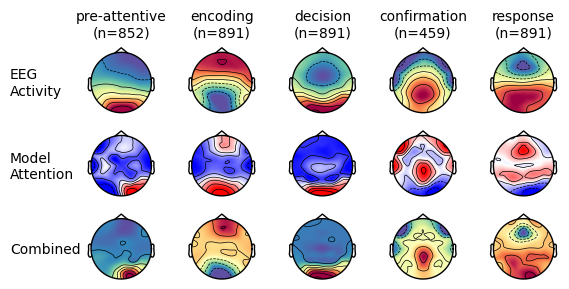

RNN


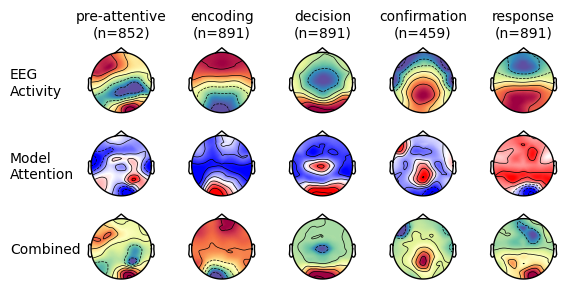

In [9]:
# Riemann_trapezoid
print("CNN")
plot_max_activation_per_label(test_data_cnn, positions)
print("RNN")
plot_max_activation_per_label(test_data_rnn, positions)

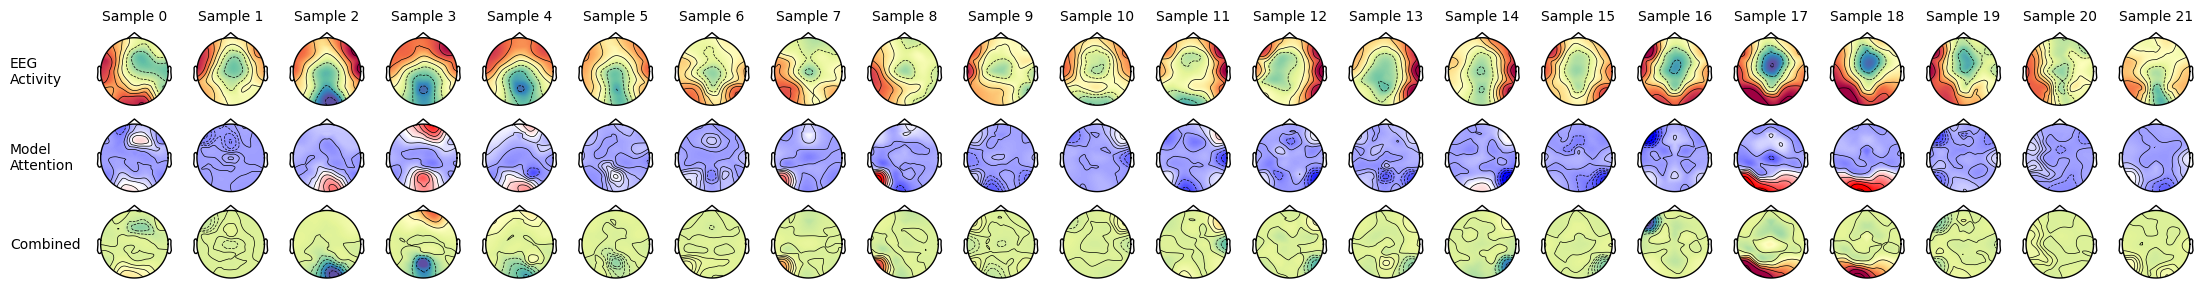

In [11]:
plot_single_trial_activation(test_data_cnn.isel(index=1), positions)


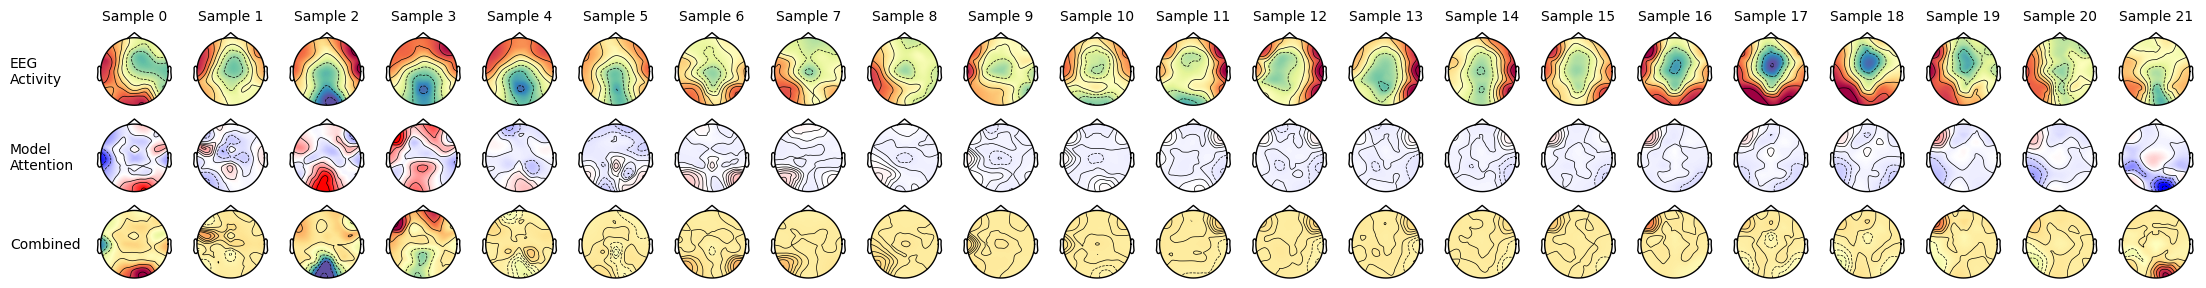

In [10]:
plot_single_trial_activation(test_data_rnn.isel(index=1), positions)

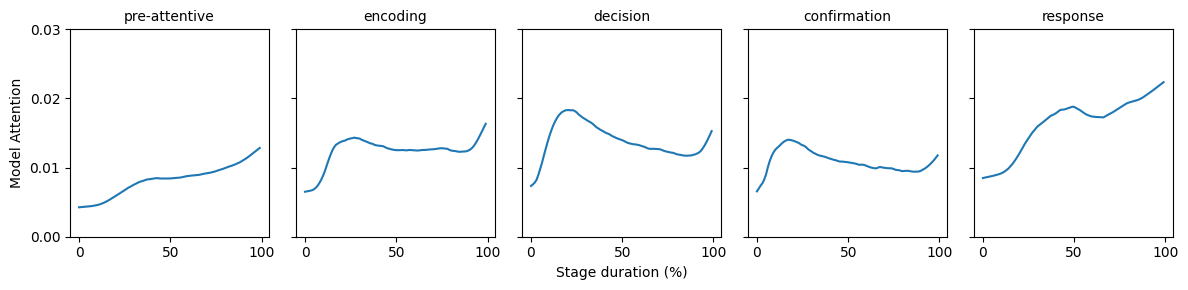

In [22]:
f, ax = plt.subplots(
    nrows=1, ncols=len(SAT1_STAGES_ACCURACY), figsize=(12, 3), sharey=True, sharex=True
)

time_points = np.linspace(0, 100, 100)
for i, label in enumerate(SAT1_STAGES_ACCURACY):
    subset = test_data_cnn.sel(labels=label)
    nan_indices = np.isnan(subset.data.where(subset.data != MASKING_VALUE)).argmax(
        dim=["samples", "channels"]
    )
    interpolated = []
    for sample, nan_index in zip(subset.analysis, nan_indices["samples"]):
        sequence = sample.mean(dim="channels")[0 : nan_index.item()]
        if len(sequence) == 0:
            continue
        origin_time_points = np.linspace(0, 100, num=len(sequence))
        interpolated_sequence = np.interp(time_points, origin_time_points, sequence)
        interpolated.append(abs(interpolated_sequence))
    ax[i].plot(np.mean(interpolated, axis=0))
    ax[i].set_title(f"{label}", fontsize=10)
    ax[i].set_yticks(np.arange(0.0, 0.040, 0.01))
# ax[2].text(0, -0.005, 'Linear interpolation\nof stage length', va='bottom', ha='center')
ax[0].set_ylabel("Model Attention")
ax[2].set_xlabel("Stage duration (%)")
plt.tight_layout()
plt.show()

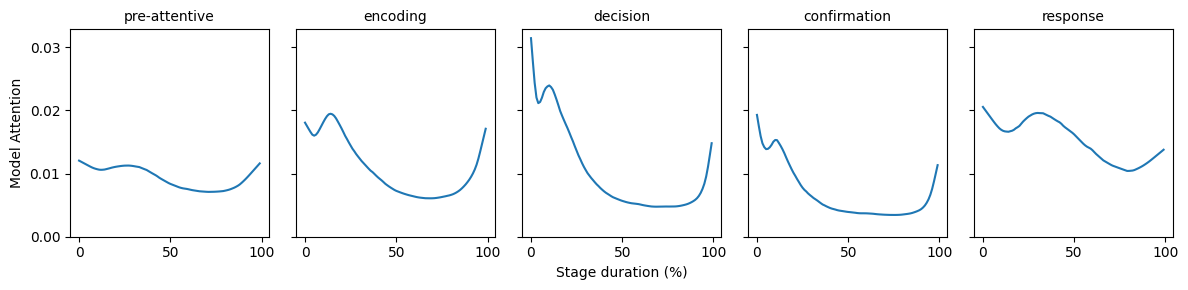

In [21]:
f, ax = plt.subplots(
    nrows=1, ncols=len(SAT1_STAGES_ACCURACY), figsize=(12, 3), sharey=True, sharex=True
)
time_points = np.linspace(0, 100, 100)
for i, label in enumerate(SAT1_STAGES_ACCURACY):
    subset = test_data_rnn.sel(labels=label)
    nan_indices = np.isnan(subset.data.where(subset.data != MASKING_VALUE)).argmax(
        dim=["samples", "channels"]
    )
    interpolated = []
    for sample, nan_index in zip(subset.analysis, nan_indices["samples"]):
        sequence = sample.mean(dim="channels")[0 : nan_index.item()]
        if len(sequence) == 0:
            continue
        origin_time_points = np.linspace(0, 100, num=len(sequence))
        interpolated_sequence = np.interp(time_points, origin_time_points, sequence)
        interpolated.append(abs(interpolated_sequence))
    ax[i].plot(np.mean(interpolated, axis=0))
    ax[i].set_title(f"{label}", fontsize=10)
    ax[i].set_yticks(np.arange(0.0, 0.040, 0.01))
    # ax[i].set_yticklabels(np.arange(0.0, 1, 1/6))
# ax[2].text(0, -0.005, 'Linear interpolation\nof stage length', va='bottom', ha='center')
ax[0].set_ylabel("Model Attention")
ax[2].set_xlabel("Stage duration (%)")
plt.tight_layout()
plt.show()